# Domain Adaptation with filters

* [ ] need to track time 

other ideas: histogram matching, colour matching, intensity matching, ...

['../helper', './helper', 'helper', 'C:\\Users\\Christina\\Documents\\datasceyence\\examples', 'C:\\Users\\Christina\\anaconda3\\envs\\chrisy\\python39.zip', 'C:\\Users\\Christina\\anaconda3\\envs\\chrisy\\DLLs', 'C:\\Users\\Christina\\anaconda3\\envs\\chrisy\\lib', 'C:\\Users\\Christina\\anaconda3\\envs\\chrisy', '', 'C:\\Users\\Christina\\anaconda3\\envs\\chrisy\\lib\\site-packages', 'C:\\Users\\Christina\\anaconda3\\envs\\chrisy\\lib\\site-packages\\pixelssl-0.1.4-py3.9.egg', 'C:\\Users\\Christina\\anaconda3\\envs\\chrisy\\lib\\site-packages\\win32', 'C:\\Users\\Christina\\anaconda3\\envs\\chrisy\\lib\\site-packages\\win32\\lib', 'C:\\Users\\Christina\\anaconda3\\envs\\chrisy\\lib\\site-packages\\Pythonwin']


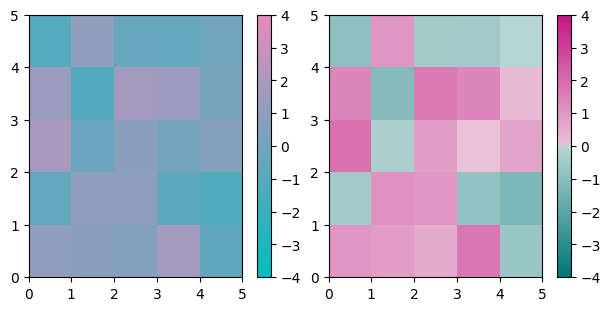

In [2]:
im_size = 300

import fda
import cv2
from skimage import io
from skimage.color import rgb2gray

import numpy as np

import matplotlib.pyplot as plt

import numpy as np
import cv2
from timeit import default_timer
# from sklearn.feature_extraction.image import extract_patches_2d

from sklearn.feature_extraction.image import extract_patches_2d as extract_patches

import skimage.io
from skimage.util import view_as_windows, random_noise
from sklearn.neighbors import NearestNeighbors

#from art2 import *
#from art2.style_transfer import *
#from art2.pca_nn import * 

import cv2

from skimage.transform import rescale, resize, downscale_local_mean

# "helper" needs to be part of sys path
import sys
sys.path.insert(0, "helper")
sys.path.insert(0, "./helper")
sys.path.insert(0, "../helper")
print(sys.path)

from dataset.transform import *

from colour import *

In [3]:
def crop_fundus(img, msk):
    
    # todo - resize to standard size at the start?? - keep dimensions
    
    if len(img.shape) == 2:
        gray = img.mean(axis=0).mean(axis=0) 
        img = cv2.copyMakeBorder(img, 400, 400, 400, 400, cv2.BORDER_CONSTANT, None, value = gray)
        img[np.where((img==0))] = gray
    else:
        gray = img.mean(axis=0).mean(axis=0)
        # image, recolour black part
        img = cv2.copyMakeBorder(img, 400, 400, 400, 400, cv2.BORDER_CONSTANT, None, value = gray)
        img[np.where((img==[0,0,0]).all(axis=2))] = gray
    
    # get center point of RoI
    msk = cv2.copyMakeBorder(msk, 400, 400, 400, 400, cv2.BORDER_REPLICATE)
    if len(msk.shape) != 2:
        msk = cv2.cvtColor(msk, cv2.COLOR_BGR2GRAY)
    num_labels, labels_im = cv2.findContours(msk, cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)    
    if len(num_labels) > 0:
        max_area = max(num_labels, key = cv2.contourArea)
        # cv2.drawContours(msk,[max_area],0,255,-1)
        # print(max_area)
        
    # calculate moments of binary image
    M = cv2.moments(max_area)
    # calculate x, y coordinate of center
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    
    plt.figure()
    plt.imshow(msk, cmap="gray")
    plt.plot(cX, cY, 'ro', lw=3) 
    
    # crop
    img = img[cY-700:cY+700, cX-700:cX+700]
    msk = msk[cY-700:cY+700, cX-700:cX+700]

    # resize
    img = cv2.resize(img, (im_size, im_size), interpolation = cv2.INTER_AREA)
    msk = cv2.resize(msk, (im_size, im_size), interpolation = cv2.INTER_AREA) 
    
    print(img.shape)
    
    return img, msk

In [4]:
domain1_img = skimage.io.imread(r'C:\Users\Prinzessin\projects\image_data\iChallenge_AMD_OD_Fovea_lesions\images_Non-AMD\N0002.jpg', as_gray=True)
domain1_msk = skimage.io.imread(r'C:\Users\Prinzessin\projects\image_data\iChallenge_AMD_OD_Fovea_lesions\Disc_Masks_bin\N0002.bmp', as_gray=True)

item = {"img" : domain1_img,
        "msk" : domain1_msk,
        "mask_crop" : True,
        "has_mask" : True
       }

cropper = MaskCrop()

item = cropper(item)

plt.figure()
plt.imshow(item["img"], cmap="gray")
plt.figure()
plt.imshow(item["msk"], cmap=variint_map1)

FileNotFoundError: No such file: 'C:\Users\Prinzessin\projects\image_data\iChallenge_AMD_OD_Fovea_lesions\images_Non-AMD\N0002.jpg'

In [5]:
fdat = FourierDomainAdapTransform()

item = fdat(item)

plt.figure()
plt.imshow(item["img"], cmap="gray")
plt.figure()
plt.imshow(item["msk"], cmap=variint_map1)

NameError: name 'item' is not defined

# Fourier Domain Adaption

In [ ]:

# Read source and target images
if False:
    domain1_img = cv2.imread(r'C:\Users\Prinzessin\projects\image_data\iChallenge_AMD_OD_Fovea_lesions\images_Non-AMD\N0002.jpg')
    domain1_msk = cv2.imread(r'C:\Users\Prinzessin\projects\image_data\iChallenge_AMD_OD_Fovea_lesions\Disc_Masks_bin\N0002.bmp')
    domain1_img, domain1_msk = crop_fundus(domain1_img, domain1_msk)
else:
    domain1_img = cv2.imread('example_data/texture/ple.tif')
    domain1_img = cv2.resize(domain1_img, (im_size, im_size), interpolation = cv2.INTER_AREA) 

domain2_img = cv2.imread('example_data/texture/cir.tif')
domain2_img = cv2.resize(domain2_img, (im_size, im_size), interpolation = cv2.INTER_AREA) 


# Perform domain adaptation
if True:
    adapted_im1 = fda.fda(domain1_img, domain2_img, beta=0.005)
    adapted_im2 = fda.fda(domain2_img, domain1_img, beta=0.005)
else:
    adapted_im1 = domain1_img
    adapted_im2 = domain2_img
        
    
    
    

In [ ]:
plt.figure()
figure, axis = plt.subplots(1, 7, figsize=(25, 5))
i = 0

axis[i].imshow(cv2.cvtColor(domain1_img, cv2.COLOR_BGR2GRAY), cmap="gray")
axis[i].set_title("domain 1")
i+=1

axis[i].imshow(cv2.cvtColor(domain2_img, cv2.COLOR_BGR2GRAY), cmap="gray")
axis[i].set_title("domain 2")
i+=1

axis[i].imshow(cv2.cvtColor(adapted_im1.astype(np.uint8), cv2.COLOR_BGR2GRAY), cmap="gray")
axis[i].set_title("D1 content + D2 style")
i+=1

axis[i].imshow(cv2.cvtColor(adapted_im2.astype(np.uint8), cv2.COLOR_BGR2GRAY), cmap="gray")
axis[i].set_title("D2 content + D1 style")
i+=1

diff2 = 255 - cv2.absdiff(cv2.cvtColor(domain1_img, cv2.COLOR_BGR2GRAY), cv2.cvtColor(adapted_im1.astype(np.uint8), cv2.COLOR_BGR2GRAY))
diff2 = cv2.cvtColor(domain1_img, cv2.COLOR_BGR2GRAY) - cv2.cvtColor(adapted_im1.astype(np.uint8), cv2.COLOR_BGR2GRAY)
                                                                     
axis[i].imshow(diff2, cmap="gray")
axis[i].set_title("Difference 1")
i+=1

diff = 255 - cv2.absdiff(cv2.cvtColor(domain2_img, cv2.COLOR_BGR2GRAY), cv2.cvtColor(adapted_im2.astype(np.uint8), cv2.COLOR_BGR2GRAY))
axis[i].imshow(diff, cmap="gray")
axis[i].set_title("Difference 2")
i+=1



from skimage.metrics import structural_similarity
from skimage.metrics import normalized_mutual_information
import cv2




# Compute SSIM between two images
(score, diff) = structural_similarity(   cv2.cvtColor(domain1_img, cv2.COLOR_BGR2GRAY), cv2.cvtColor(adapted_im1.astype(np.uint8), cv2.COLOR_BGR2GRAY)   , full=True)
# The diff image contains the actual image differences between the two images
# and is represented as a floating point data type in the range [0,1] 
# so we must convert the array to 8-bit unsigned integers in the range
# [0,255] before we can use it with OpenCV
diff = (diff * 255).astype("uint8")
axis[i].imshow(diff, cmap="gray")
axis[i].set_title("structural sim")
i+=1

# Style Transfer Using Texture Synthesis

In [ ]:
# https://arxiv.org/pdf/1609.03057.pdf https://github.com/DarkGeekMS/artistic-style-transfer-using-texture-synthesis/blob/master/src/style_transfer.py

In [ ]:
#source_im = cv2.imread('example_data/AMD/A0001.jpg') 
#source_im = cv2.imread(r'C:\Users\Prinzessin\projects\image_data\iChallenge_AMD_OD_Fovea_lesions\images_Non-AMD\N0067.jpg') # example_data/nonAMD/N0002.jpg') 
#source_im = cv2.imread('example_data/texture/ple.tif')
#source_im = cv2.imread('example_data/texture/cir.tif')
#target_im = cv2.imread('example_data/texture/cir.tif')
#target_im = cv2.imread('example_data/texture/ple.tif')

# output_img = style_transfer(source_im, t, num_pyramid_layers=3, patch_sizes=(50, 40, 30), patch_spacings=(10, 10, 10), num_iters=3, num_irls_iters=10, max_pixel_val=255)
# num_pyramid_layers=3, patch_sizes=(33, 21, 13, 9), patch_spacings=(28, 18, 8, 5), num_iters=3, num_irls_iters=10, max_pixel_val=255


# Read source and target images    
if True:
    domain1_img = cv2.imread(r'C:\Users\Prinzessin\projects\image_data\iChallenge_AMD_OD_Fovea_lesions\images_Non-AMD\N0002.jpg')
    domain1_msk = cv2.imread(r'C:\Users\Prinzessin\projects\image_data\iChallenge_AMD_OD_Fovea_lesions\Disc_Masks_bin\N0002.bmp')
    domain1_img, domain1_msk = crop_fundus(domain1_img, domain1_msk)
    c_domain1_img = domain1_img
else:
    domain1_img = cv2.imread('example_data/texture/ple.tif')
    domain1_img = cv2.resize(domain1_img, (im_size, im_size), interpolation = cv2.INTER_AREA) 
    c_domain1_img = domain1_img.copy()
    c_domain1_img[:,:,0] = domain1_img[:,:,0] * 1.1 # if all channels have same value it does weird stuff
    c_domain1_img[:,:,1] = domain1_img[:,:,2] * 0.9 # if all channels have same value it does weird stuff

domain2_img = cv2.imread('example_data/texture/cir.tif')
domain2_img = cv2.resize(domain2_img, (im_size, im_size), interpolation = cv2.INTER_AREA) 
c_domain2_img = domain2_img.copy()
c_domain2_img[:,:,0] = c_domain2_img[:,:,0] * 1.1 # if all channels have same value it does weird stuff
c_domain2_img[:,:,1] = c_domain2_img[:,:,2] * 0.9 # if all channels have same value it does weird stuff


# Perform domain adaptation
if True:
    adapted_im1 = style_transfer(domain1_img, c_domain2_img, num_pyramid_layers=2, patch_sizes=(40,30,20), patch_spacings=(10, 10, 10), num_iters=3, num_irls_iters=3, max_pixel_val=255, im_size=im_size)
    print("done adapted_im1")
    adapted_im2 = style_transfer(domain2_img, c_domain1_img, num_pyramid_layers=2, patch_sizes=(40,30,20), patch_spacings=(10, 10, 10), num_iters=3, num_irls_iters=3, max_pixel_val=255, im_size=im_size)
    print("done adapted_im2")
else:
    adapted_im1 = domain1_img
    adapted_im2 = domain2_img








In [ ]:
plt.figure()
figure, axis = plt.subplots(1, 4, figsize=(25, 5))
i = 0

axis[i].imshow(cv2.cvtColor(domain1_img, cv2.COLOR_BGR2GRAY), cmap="gray")
i+=1

axis[i].imshow(cv2.cvtColor(domain2_img, cv2.COLOR_BGR2GRAY), cmap="gray")
i+=1

#axis[i].imshow(cv2.cvtColor(target2, cv2.COLOR_BGR2GRAY), cmap="gray")
#i+=1

axis[i].imshow(cv2.cvtColor(adapted_im1.astype(np.uint8), cv2.COLOR_BGR2GRAY), cmap="gray")
i+=1

axis[i].imshow(cv2.cvtColor(adapted_im2.astype(np.uint8), cv2.COLOR_BGR2GRAY), cmap="gray")
i+=1


In [ ]:
plt.figure()
figure, axis = plt.subplots(1, 4, figsize=(25, 5))
i = 0

axis[i].imshow(cv2.cvtColor(domain1_img, cv2.COLOR_BGR2GRAY), cmap="gray")
i+=1

axis[i].imshow(cv2.cvtColor(domain2_img, cv2.COLOR_BGR2GRAY), cmap="gray")
i+=1

#axis[i].imshow(cv2.cvtColor(target2, cv2.COLOR_BGR2GRAY), cmap="gray")
#i+=1

axis[i].imshow(cv2.cvtColor(adapted_im1.astype(np.uint8), cv2.COLOR_BGR2GRAY), cmap="gray")
i+=1

axis[i].imshow(cv2.cvtColor(adapted_im2.astype(np.uint8), cv2.COLOR_BGR2GRAY), cmap="gray")
i+=1


In [ ]:
import colortrans
import numpy as np
from PIL import Image

from color_transfer import color_transfer

from python_color_transfer.color_transfer import ColorTransfer

# Load data
if False:
    domain1_img = cv2.imread('example_data/texture/ple.tif')
    domain1_img = cv2.resize(domain1_img, (im_size, im_size), interpolation = cv2.INTER_AREA) 
    domain1_img[:,:,0] = domain1_img[:,:,0] * 0.99 # if all channels have same value it does weird stuff
    domain1_img[:,:,2] = domain1_img[:,:,2] * 0.995 # if all channels have same value it does weird stuff

else:
    domain1_img = cv2.imread(r'C:\Users\Prinzessin\projects\image_data\iChallenge_AMD_OD_Fovea_lesions\images_Non-AMD\N0009.jpg')
    domain1_msk = cv2.imread(r'C:\Users\Prinzessin\projects\image_data\iChallenge_AMD_OD_Fovea_lesions\Disc_Masks_bin\N0009.bmp')
    domain1_img, domain1_msk = crop_fundus(domain1_img, domain1_msk)
    domain1_img = cv2.resize(domain1_img, (im_size, im_size), interpolation = cv2.INTER_AREA) 


domain2_img = cv2.imread('example_data/texture/cir.tif')
domain2_img = cv2.resize(domain2_img, (im_size, im_size), interpolation = cv2.INTER_AREA) 

domain2_img[:,:,0] = domain2_img[:,:,0] * 0.91 # if all channels have same value it does weird stuff
domain2_img[:,:,2] = domain2_img[:,:,2] * 0.90 # if all channels have same value it does weird stuff


# Transfer colors using different algorithms
output_lhm = colortrans.transfer_lhm(domain1_img, domain2_img)
output_pccm = colortrans.transfer_pccm(domain1_img, domain2_img)
output_rein = colortrans.transfer_reinhard(domain1_img, domain2_img)
outout_col = color_transfer(domain2_img, domain1_img)


python_color_transfer = ColorTransfer()

#img_arr_pdf_reg = python_color_transfer.pdf_tranfer(img_arr_in=domain1_img,
#                             img_arr_ref=domain2_img,
#                             regrain=True)
# Mean std transfer
img_arr_mt = python_color_transfer.mean_std_transfer(img_arr_in=domain1_img,
                                  img_arr_ref=domain2_img)
# Lab mean transfer
img_arr_lt = python_color_transfer.lab_transfer(img_arr_in=domain1_img, img_arr_ref=domain2_img)

print("*")
print(img_arr_lt.shape)
print("*")
print(img_arr_mt.shape)
print("*")


plt.figure()
figure, axis = plt.subplots(1, 8, figsize=(25, 5))
i = 0

axis[i].imshow(cv2.cvtColor(domain1_img, cv2.COLOR_BGR2GRAY), cmap="gray")
i+=1

axis[i].imshow(cv2.cvtColor(domain2_img, cv2.COLOR_BGR2GRAY), cmap="gray")
i+=1

axis[i].imshow(cv2.cvtColor(outout_col, cv2.COLOR_BGR2GRAY), cmap="gray")
i+=1

axis[i].imshow(cv2.cvtColor(img_arr_mt, cv2.COLOR_BGR2GRAY), cmap="gray")
i+=1

axis[i].imshow(cv2.cvtColor(img_arr_lt, cv2.COLOR_BGR2GRAY), cmap="gray")
i+=1

axis[i].imshow(cv2.cvtColor(output_lhm, cv2.COLOR_BGR2GRAY), cmap="gray")
i+=1

axis[i].imshow(cv2.cvtColor(output_pccm, cv2.COLOR_BGR2GRAY), cmap="gray")
i+=1

axis[i].imshow(cv2.cvtColor(output_rein, cv2.COLOR_BGR2GRAY), cmap="gray")
i+=1

"""
diff = 255 - cv2.absdiff(cv2.cvtColor(img_arr_mt, cv2.COLOR_BGR2GRAY), cv2.cvtColor(domain1_img, cv2.COLOR_BGR2GRAY))

print(diff)

#diff = cv2.cvtColor(diff, cv2.COLOR_GRAY2RGB)
#print(diff.shape)

#diff[:,:,0] = diff[:,:,0] * 100

#print(diff)

#print(diff.shape)

#

axis[i].imshow(diff, cmap="gray")
i+=1

(score, diff2) = structural_similarity(    cv2.cvtColor(img_arr_mt, cv2.COLOR_BGR2GRAY), cv2.cvtColor(domain1_img, cv2.COLOR_BGR2GRAY)   , full=True)
# The diff image contains the actual image differences between the two images
# and is represented as a floating point data type in the range [0,1] 
# so we must convert the array to 8-bit unsigned integers in the range
# [0,255] before we can use it with OpenCV
diff2 = (diff2 * 255).astype("uint8")

axis[i].imshow(diff2, cmap="gray")
i+=1
"""